In [1]:
#Imports
from tcn import TCN, tcn_full_summary
import pandas as pd
import numpy  as np
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from tensorflow import keras
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

In [2]:
def plot_history(history):
    plt.figure(figsize=(15,8))
    plt.plot(history.history['loss'], label = 'train loss')
    plt.plot(history.history['val_loss'], label='validation loss')
    plt.title("Loss vs Validation Loss (MSE)")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()
    #Mean Absolute Error graph
    plt.figure(figsize=(15,8))
    plt.plot(history.history['mae'], label = 'Train MAE')
    plt.plot(history.history['val_mae'], label='Val MAE')
    plt.title("Mean Absolute Error vs Validation MAE")
    plt.xlabel("Epochs")
    plt.ylabel("MAE")
    plt.legend()
    plt.show()

In [3]:
#Reading and parsing train data
train_data = pd.read_csv('BigData_Train/2022-10-13-17-15-09-joint_states.csv')
train_data['.position'] = train_data['.position'].str.strip('()')
train_data['.velocity'] = train_data['.velocity'].str.strip('()')
train_data['.effort'] = train_data['.effort'].str.strip('()')
time_stamp = train_data[['.header.stamp.nsecs']]
position = train_data['.position'].str.split(',', expand=True)
velocity = train_data['.velocity'].str.split(',', expand=True)
effort = train_data['.effort'].str.split(',', expand=True)

In [4]:
foot_contacts = pd.read_csv('BigData_Train/2022-10-13-17-15-09-foot_contacts.csv')
foot_contacts['.contacts'] = foot_contacts['.contacts'].str.strip('[]')
foot_contacts = foot_contacts['.contacts'].str.split(',', expand=True)
foot_contacts = foot_contacts.replace('True',1, regex=True)
foot_contacts = foot_contacts.replace('False',0, regex=True)
foot_contacts.head()

,0,1,2,3
0,1,1,1,1
1,1,1,1,1
2,1,1,1,1
3,1,1,1,1
4,1,1,1,1


In [5]:
features = pd.concat([position, velocity, effort, foot_contacts], axis=1)

In [ ]:
features

In [7]:
x = features.values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
features = pd.DataFrame(x_scaled)

In [8]:
features.shape

(26450, 40)

In [9]:
groundTruth = pd.read_csv("BigData_Train/2022-10-13-17-15-09-ground_truth-state.csv", sep=',')
Xtargets = groundTruth[['.pose.pose.position.x']]
Ytargets = groundTruth[['.pose.pose.position.y']]

In [10]:
x = Xtargets.values  #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
Xtargets = pd.DataFrame(x_scaled)

In [11]:
#Scaling Y targets in train data
x = Ytargets.values  #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
Ytargets = pd.DataFrame(x_scaled)

In [12]:
#Converting values of (x,y) and features to float
Xtargets = np.asarray(Xtargets).astype(np.float64)
Ytargets = np.asarray(Ytargets).astype(np.float64)
features = np.asarray(features).astype(np.float64)

In [13]:
#Reading and parsing test data
test_data = pd.read_csv('BigData_Test/2022-10-13-17-38-08-joint_states.csv')
test_data['.position'] = test_data['.position'].str.strip('()')
test_data['.velocity'] = test_data['.velocity'].str.strip('()')
test_data['.effort'] = test_data['.effort'].str.strip('()')
time_stamp = test_data[['.header.stamp.nsecs']]
position = test_data['.position'].str.split(',', expand=True)
velocity = test_data['.velocity'].str.split(',', expand=True)
effort = test_data['.effort'].str.split(',', expand=True)

In [14]:
foot_contacts_test = pd.read_csv('BigData_Test/2022-10-13-17-38-08-foot_contacts.csv')
foot_contacts_test['.contacts'] = foot_contacts_test['.contacts'].str.strip('[]')
foot_contacts_test = foot_contacts_test['.contacts'].str.split(',', expand=True)
foot_contacts_test = foot_contacts_test.replace('True', 1, regex=True)
foot_contacts_test = foot_contacts_test.replace('False', 0, regex=True)
foot_contacts_test.head()

,0,1,2,3
0,1,1,1,1
1,1,1,1,1
2,1,1,1,1
3,1,1,1,1
4,1,1,1,1


In [15]:
features_test = pd.concat([position, velocity, effort, foot_contacts_test], axis=1)
features_test.shape

(2050, 40)

In [16]:
x = features_test.values  #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
features_test = pd.DataFrame(x_scaled)

In [17]:
groundTruth_test = pd.read_csv("BigData_Test/2022-10-13-17-38-08-ground_truth-state.csv", sep=',')
Xtargets_test = groundTruth_test[['.pose.pose.position.x']]
Ytargets_test = groundTruth_test[['.pose.pose.position.y']]

In [18]:
#Scaling X targets in train data
x = Xtargets_test.values  #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
Xtargets_test = pd.DataFrame(x_scaled)

In [19]:
#Scaling Y targets in train data
x = Ytargets_test.values  #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
Ytargets_test = pd.DataFrame(x_scaled)

In [20]:
#Converting values of (x,y) and features to float
Xtargets_test = np.asarray(Xtargets_test).astype(np.float64)
Ytargets_test = np.asarray(Ytargets_test).astype(np.float64)
features_test = np.asarray(features_test).astype(np.float64)

In [21]:
Xtargets.shape

(26450, 1)

In [22]:
sample_size = features.shape[0] # number of samples in train set
time_steps  = features.shape[1] # number of features in train set
input_dimension = 1               # each feature is represented by 1 number
features_reshaped = features.reshape(sample_size, time_steps, input_dimension)

In [23]:
features_reshaped.shape

(26450, 40, 1)

In [24]:
sample_size = features_test.shape[0] # number of samples in train set
time_steps  = features_test.shape[1] # number of features in train set
input_dimension = 1               # each feature is represented by 1 number
features_test_reshaped = features_test.reshape(sample_size, time_steps, input_dimension)

In [25]:
features_test_reshaped.shape

(2050, 40, 1)

In [26]:
n_timesteps = features_reshaped.shape[1] #13
n_features  = features_reshaped.shape[2] #1

model = keras.Sequential(name="model_conv1D")
model.add(keras.layers.Input(shape=(n_timesteps,n_features)))
model.add(keras.layers.Conv1D(filters=5, kernel_size=16, strides=1, dilation_rate=1, activation='relu'))
model.add(keras.layers.Conv1D(filters=5, kernel_size=8, strides=2, dilation_rate=1, activation='relu'))
model.add(keras.layers.Conv1D(filters=5, kernel_size=3, strides=1, dilation_rate=2, activation='relu'))
model.add(keras.layers.Conv1D(filters=5, kernel_size=2,  strides=2, dilation_rate=1, activation='relu'))
model.add(keras.layers.Conv1D(filters=5, kernel_size=1,  strides=1, dilation_rate=4, activation='relu'))
model.add(keras.layers.Conv1D(filters=5, kernel_size=1,  strides=2, dilation_rate=1, activation='relu'))
model.add(Dense(64, activation='tanh'))
model.add(Dense(256, activation='tanh'))
model.add(Dense(128, activation='tanh'))
model.add(Dense(64, activation='tanh'))
model.add(keras.layers.Dense(n_features))


optimizer = tf.keras.optimizers.Adam(learning_rate=0.0005)

model.compile(loss='mse',optimizer=optimizer, metrics=['mae'])
model.summary()

Model: "model_conv1D"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 25, 5)             85        
                                                                 
 conv1d_1 (Conv1D)           (None, 9, 5)              205       
                                                                 
 conv1d_2 (Conv1D)           (None, 5, 5)              80        
                                                                 
 conv1d_3 (Conv1D)           (None, 2, 5)              55        
                                                                 
 conv1d_4 (Conv1D)           (None, 2, 5)              30        
                                                                 
 conv1d_5 (Conv1D)           (None, 1, 5)              30        
                                                                 
 dense (Dense)               (None, 1, 64)            

In [ ]:
history = model.fit(features_reshaped, Xtargets, epochs=10, validation_split=0.2, verbose=2)

In [29]:
lossX, maeX = model.evaluate(features_test_reshaped, Xtargets_test)
print(f"Loss is {lossX},\nMAE is {maeX * 100}%")

65/65 [==============================] - 0s 1ms/step - loss: 0.0733 - mae: 0.2236
Loss is 0.07326309382915497,
MAE is 22.361448407173157%


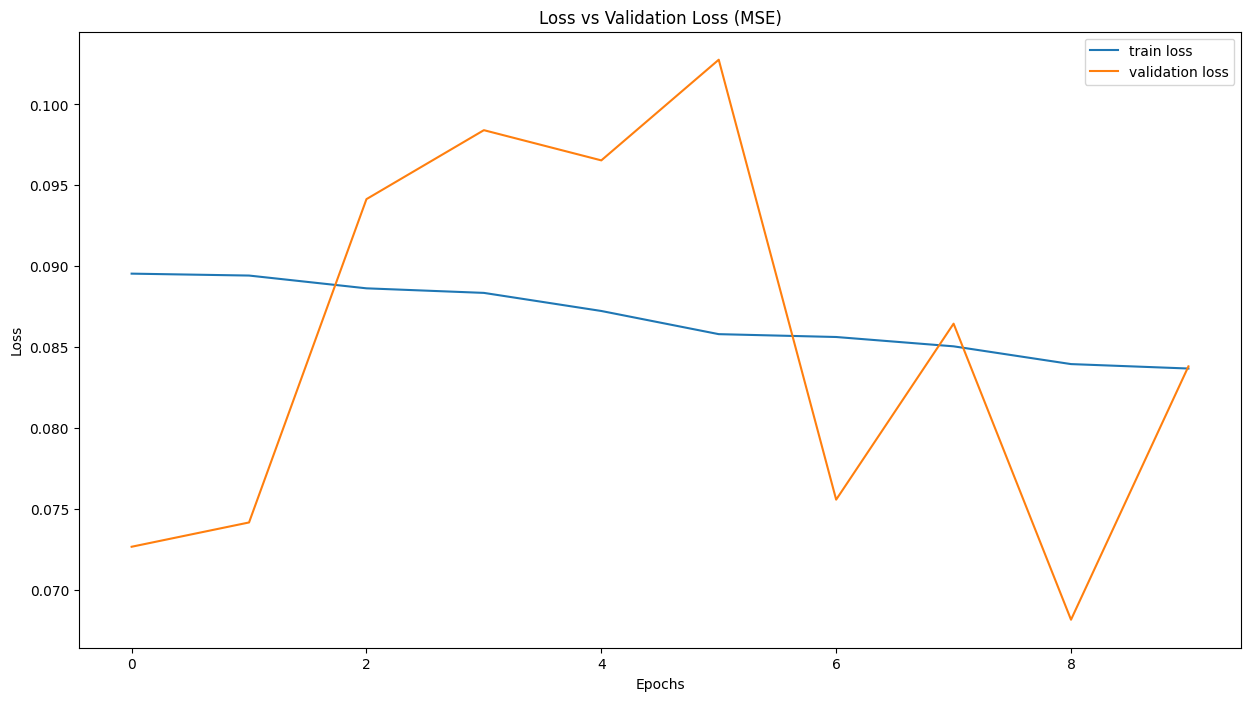

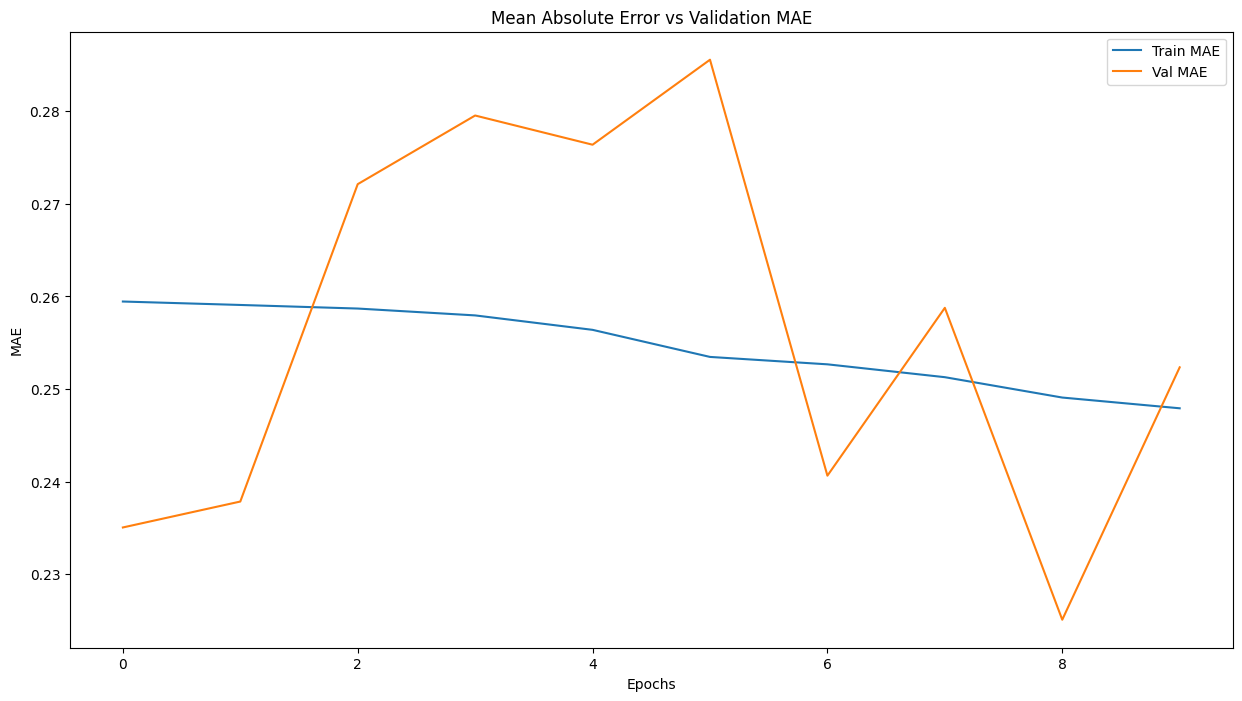

In [30]:
#Loss and MAE graph
plot_history(history)

In [36]:
modelY = keras.Sequential(name="Ymodel_conv1D")
modelY.add(keras.layers.Input(shape=(n_timesteps,n_features)))
modelY.add(keras.layers.Conv1D(filters=5, kernel_size=16, strides=1, dilation_rate=1, activation='relu'))
modelY.add(keras.layers.Conv1D(filters=5, kernel_size=8, strides=2, dilation_rate=1, activation='relu'))
modelY.add(keras.layers.Conv1D(filters=5, kernel_size=3, strides=1, dilation_rate=2, activation='relu'))
modelY.add(keras.layers.Conv1D(filters = 5, kernel_size=2,  strides=2, dilation_rate=1, activation='relu'))
modelY.add(keras.layers.Conv1D(filters = 5, kernel_size=1,  strides=1, dilation_rate=4, activation='relu'))
modelY.add(keras.layers.Conv1D(filters = 5, kernel_size=1,  strides=2, dilation_rate=1, activation='relu'))
modelY.add(Dense(64, activation='tanh'))
modelY.add(Dense(256, activation='tanh'))
modelY.add(Dense(128, activation='tanh'))
modelY.add(Dense(64, activation='tanh'))
modelY.add(keras.layers.Dense(n_features))

optimizer = tf.keras.optimizers.Adam(learning_rate=0.0005)

modelY.compile(loss='mse',optimizer=optimizer, metrics=['mae'])
modelY.summary()

Model: "Ymodel_conv1D"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_12 (Conv1D)          (None, 25, 5)             85        
                                                                 
 conv1d_13 (Conv1D)          (None, 9, 5)              205       
                                                                 
 conv1d_14 (Conv1D)          (None, 5, 5)              80        
                                                                 
 conv1d_15 (Conv1D)          (None, 2, 5)              55        
                                                                 
 conv1d_16 (Conv1D)          (None, 2, 5)              30        
                                                                 
 conv1d_17 (Conv1D)          (None, 1, 5)              30        
                                                                 
 dense_10 (Dense)            (None, 1, 64)           

In [ ]:
historyY = modelY.fit(features_reshaped, Ytargets, epochs=10, validation_split=0.2, verbose=2)

In [38]:
[lossY, maeY] = modelY.evaluate(features_test_reshaped, Ytargets_test)
print(f"Loss is {lossY},\nMAE is {maeY * 100}%")

65/65 [==============================] - 0s 884us/step - loss: 0.1282 - mae: 0.2907
Loss is 0.12822654843330383,
MAE is 29.065927863121033%


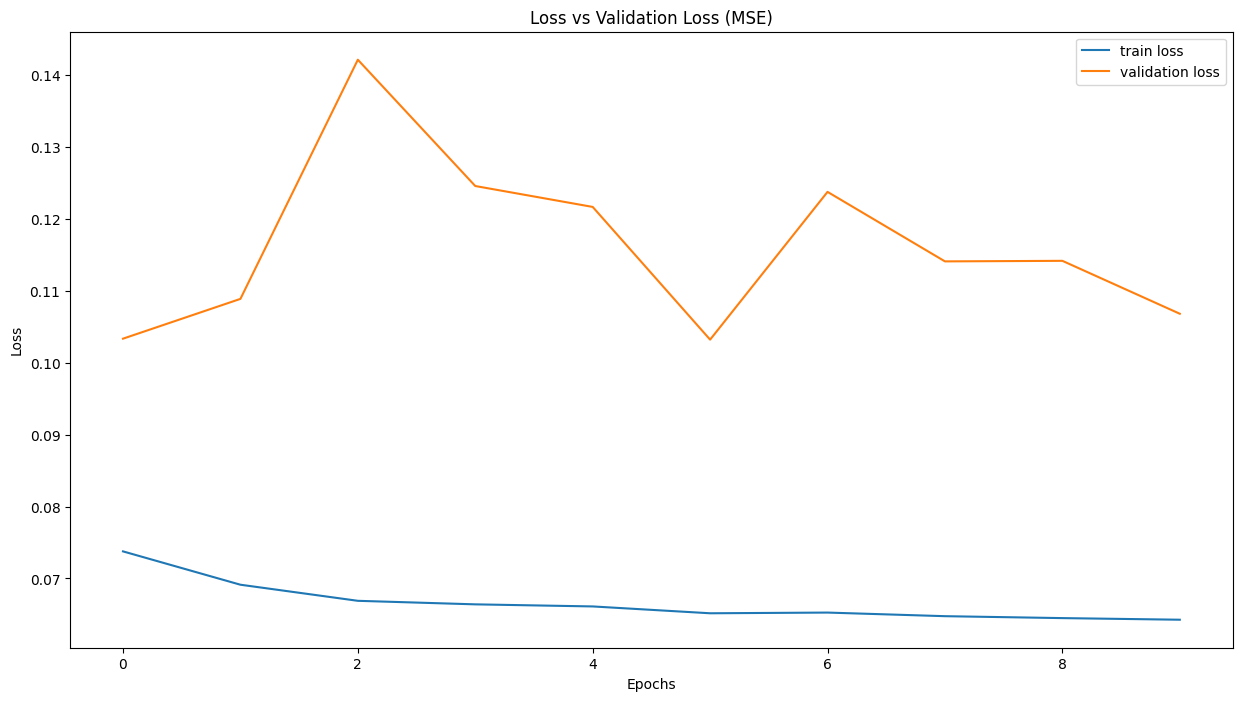

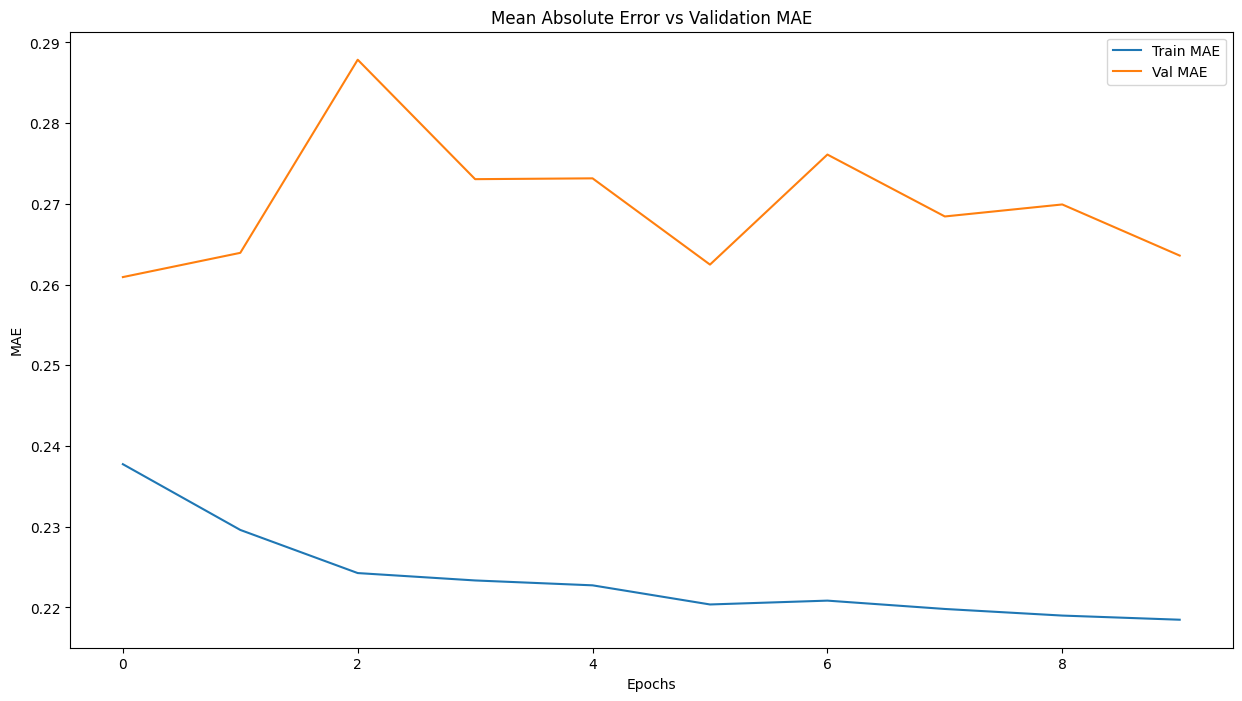

In [39]:
plot_history(historyY)

65/65 [==============================] - 0s 1ms/step


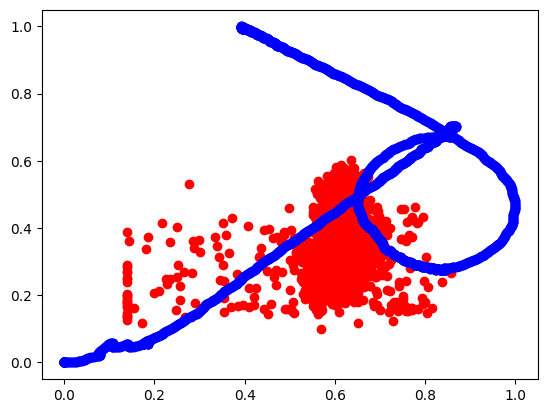

In [40]:
yhatX = model.predict(features_test_reshaped)
yhatY = modelY.predict(features_test_reshaped)
yhatX = yhatX.reshape(-1,1)
yhatY = yhatY.reshape(-1,1)
plt.scatter(yhatX, yhatY, color='red')
plt.scatter(Xtargets_test, Ytargets_test, color='blue')
#plt.scatter(x_odom, y_odom, color='orange')
plt.show()

In [ ]:
yhatY.reshape(-1,1)